In [2]:
using BenchmarkTools
using Combinatorics

include("../phase1/node.jl")
include("../phase1/edges.jl")
include("../phase1/graph.jl")
include("../phase1/read_stsp.jl")
include("../phase2/comp_connexes.jl")
include("../phase1/main.jl")
include("../phase2/queue.jl")
include("../phase2/heuristics.jl")
include("../phase2/Kruskal.jl")
include("../phase2/prims_algorithm.jl")
include("../phase3/hk.jl")
include("../phase3/rsl.jl")

Graph Test has 9 nodes.
Node a, data: [0.0]
Node b, data: [0.0]
Node c, data: [0.0]
Node d, data: [0.0]
Node e, data: [0.0]
Node f, data: [0.0]
Node g, data: [0.0]
Node h, data: [0.0]
Node i, data: [0.0]
Graph Test has 8 edges.
Arête de h à a, poids: 8.0
Arête de a à b, poids: 4.0
Arête de f à c, poids: 4.0
Arête de c à d, poids: 7.0
Arête de d à e, poids: 9.0
Arête de f à g, poids: 2.0
Arête de g à h, poids: 1.0
Arête de c à i, poids: 2.0


sum of weights37.0
Graph 

Test has 9 nodes.
Node a, data: [0.0]
Node b, data: [0.0]
Node c, data: [0.0]
Node d, data: [0.0]
Node e, data: [0.0]
Node f, data: [0.0]
Node g, data: [0.0]
Node h, data: [0.0]
Node i, data: [0.0]
Graph Test has 8 edges.
Arête de h à a, poids: 8.0
Arête de a à b, poids: 4.0
Arête de f à c, poids: 4.0
Arête de c à d, poids: 7.0
Arête de d à e, poids: 9.0
Arête de f à g, poids: 2.0
Arête de g à h, poids: 1.0
Arête de c à i, poids: 2.0
sum of weights37.0
Graph 

Test has 9 nodes.
Node a, data: [0.0]
Node b, data: [0.0]
Node c, data: [0.0]
Node d, data: [0.0]
Node e, data: [0.0]
Node f, data: [0.0]
Node g, data: [0.0]
Node h, data: [0.0]
Node i, data: [0.0]
Graph Test has 8 edges.
Arête de h à a, poids: 8.0
Arête de a à b, poids: 4.0
Arête de f à c, poids: 4.0
Arête de c à d, poids: 7.0
Arête de d à e, poids: 9.0
Arête de f à g, poids: 2.0
Arête de g à h, poids: 1.0
Arête de c à i, poids: 2.0
sum of weights37.0


rsl

In [3]:
graphe_test = Graph("Test",Node{Vector{Float64}}[],Edge{Int,Vector{Float64}}[])

#Nodes 
nodea = Node("a",[0.])
nodeb = Node("b",[0.])
nodec = Node("c",[0.])
noded = Node("d",[0.])
nodee = Node("e",[0.])
nodef = Node("f",[0.])
nodeg = Node("g",[0.])
nodeh = Node("h",[0.])
nodei = Node("i",[0.])
node_list = [nodea,nodeb,nodec, noded,nodee, nodef, 
                nodeg, nodeh, nodei]

#Edges
edge1 = Edge(nodea,nodeb, 4)
edge2 = Edge(nodea,nodeh, 8)
edge3 = Edge(nodeb, nodeh, 11)
edge4 = Edge(nodeb, nodec, 8)
edge5 = Edge(nodeh, nodei, 7)
edge6 = Edge(nodeh, nodeg, 1)
edge7 = Edge(nodeg, nodei, 6)
edge8 = Edge(nodeg, nodef, 2)
edge9 = Edge(nodec, nodef, 4)
edge10 = Edge(nodei, nodec, 2)
edge11 = Edge(nodef, nodee, 10)
edge12 = Edge(nodee, noded, 9)
edge13 = Edge(nodec,noded, 7)
edge14 = Edge(noded, nodef, 14)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10, edge11,
                edge12, edge13, edge14]

##Construction du graphe
for i in node_list
    add_node!(graphe_test,i)
end
for i in edge_list
    add_edge!(graphe_test, i)
end


In [4]:
tree, root = prims_algorithm(graphe_test)
show(tree)


Node a has  rank 0 and 1 children.
It has no parent.
Its children are: 
     b
Node b has  rank 0 and 1 children.
Its parent is a
Its children are: 
     c
Node c has  rank 0 and 3 children.
Its parent is b
Its children are: 
     d
     f
     i
Node d has  rank 0 and 1 children.
Its parent is c
Its children are: 
     e
Node e has  rank 0 and 0 children.
Its parent is d
It has no children.
Node f has  rank 0 and 1 children.
Its parent is c
Its children are: 
     g
Node g has  rank 0 and 1 children.
Its parent is f
Its children are: 
     h
Node h has  rank 0 and 0 children.
Its parent is g
It has no children.
Node i has  rank 0 and 0 children.
Its parent is c
It has no children.


In [5]:
priority_queue, tree = prims_priority_queue(graphe_test, "a")

p_tree, root = prims_algorithm(graphe_test, start_node_name = "a")
p_graph = tree_to_graph(p_tree, root)
show(p_graph)
println("sum of weights = ", sum_of_weights(p_graph))
kruskal_tree, root = kruskal(graphe_test, start_node_name = "a")
k_graph = tree_to_graph(kruskal_tree, root)
show(k_graph)
println("kruskal",sum_of_weights(k_graph))


Graph Test has 9 nodes.
Node a, data: [0.0]
Node b, data: [0.0]
Node c, data: [0.0]
Node d, data: [0.0]
Node e, data: [0.0]
Node f, data: [0.0]
Node g, data: [0.0]
Node h, data: [0.0]
Node i, data: [0.0]
Graph Test has 8 edges.
Arête de a à b, poids: 4.0
Arête de b à c, poids: 8.0
Arête de c à d, poids: 7.0
Arête de d à e, poids: 9.0
Arête de c à f, poids: 4.0
Arête de f à g, poids: 2.0
Arête de g à h, poids: 1.0
Arête de c à i, poids: 2.0
sum of weights = 37.0
Graph Test has 9 nodes.
Node a, data: [0.0]
Node b, data: [0.0]
Node c, data: [0.0]
Node d, data: [0.0]
Node e, data: [0.0]
Node f, data: [0.0]
Node g, data: [0.0]
Node h, data: [0.0]
Node i, data: [0.0]
Graph Test has 8 edges.
Arête de h à a, poids: 8.0
Arête de a à b, poids: 4.0
Arête de f à c, poids: 4.0
Arête de c à d, poids: 7.0
Arête de d à e, poids: 9.0
Arête de f à g, poids: 2.0
Arête de g à h, poids: 1.0
Arête de c à i, poids: 2.0
kruskal37.0


In [6]:
#@benchmark kruskal(graphe_test)

In [7]:
@time p_tree1, root1 = prims_algorithm(graphe_test, start_node_name = "a")

  0.000073 seconds (385 allocations: 25.266 KiB)


(Tree{Vector{Float64}}("Test", TreeNode{Vector{Float64}}[TreeNode{Vector{Float64}}("a", [0.0], nothing, [2], 0, 0, 1), TreeNode{Vector{Float64}}("b", [0.0], 1, [3], 4, 0, 2), TreeNode{Vector{Float64}}("c", [0.0], 2, [4, 6, 9], 8, 0, 3), TreeNode{Vector{Float64}}("d", [0.0], 3, [5], 7, 0, 4), TreeNode{Vector{Float64}}("e", [0.0], 4, Int64[], 9, 0, 5), TreeNode{Vector{Float64}}("f", [0.0], 3, [7], 4, 0, 6), TreeNode{Vector{Float64}}("g", [0.0], 6, [8], 2, 0, 7), TreeNode{Vector{Float64}}("h", [0.0], 7, Int64[], 1, 0, 8), TreeNode{Vector{Float64}}("i", [0.0], 3, Int64[], 2, 0, 9)]), TreeNode{Vector{Float64}}("a", [0.0], nothing, [2], 0, 0, 1))

In [8]:
swiss_42_graph, swiss_42_nodes = graph_from_tsp("../../instances/stsp/swiss42.tsp","graphe1")
println("running Prim's algorithm on swiss42")
@time swiss_42_tree, root2 = prims_algorithm(swiss_42_graph)
swiss_42 = tree_to_graph(swiss_42_tree, root2)
sum_of_weights(swiss_42)

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
running Prim's algorithm on swiss42
  0.032790 seconds (46.54 k allocations: 2.631 MiB, 95.85% compilation time)


1079.0

In [9]:
#running kruskal on swiss 42
println("running Kruskal's algorithm on swiss42")
swiss_42_tree, root = kruskal(swiss_42_graph)
swiss_42 = tree_to_graph(swiss_42_tree, root)
sum_of_weights(swiss_42)

running Kruskal's algorithm on swiss42


1079.0

In [10]:
graphe1, graphe1_nodes = graph_from_tsp("../../instances/stsp/bays29.tsp","graphe1")
println("running Prim's algorithm")
@time bays_29_tree, root3 = prims_algorithm(graphe1)
bays_29_graph = tree_to_graph(bays_29_tree, root3)

sum_of_weights(bays_29_graph)

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
running Prim's algorithm
  0.000593 seconds (6.83 k allocations: 252.438 KiB)

1557.0

In [11]:
println("running Kruskal's algorithm")
bays_29_tree,root = kruskal(graphe1)
#show(bays_29_tree)
bays_29_graph = tree_to_graph(bays_29_tree, root)
sum_of_weights(bays_29_graph)

running Kruskal's algorithm


1557.0

## Algorithm de Held et Karp 

In [12]:


nodea = Node("a",[0.])
nodeb = Node("b",[0.])
nodec = Node("c",[0.])
noded = Node("d",[0.])
nodee = Node("e",[0.])
node_list = [nodea,nodeb,nodec, noded,nodee]
#Edges are fully connected
edge1 = Edge(nodea,nodeb, 3.)
edge2 = Edge(nodea,nodec, 2.)
edge3 = Edge(nodea, noded, 11.)
edge4 = Edge(nodea, nodee, 9.)
edge5 = Edge(nodeb, nodec, 1.)
edge6 = Edge(nodeb, noded, 12.)
edge7 = Edge(nodeb, nodee, 6.)
edge8 = Edge(nodec, noded, 6.)
edge9 = Edge(nodec, nodee, 4.)
edge10 = Edge(noded, nodee, 7.)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10]

tsp_test = Graph("Test",node_list,edge_list)
tsp_test



Graph{Vector{Float64}, Float64}("Test", Node{Vector{Float64}}[Node{Vector{Float64}}("a", [0.0]), Node{Vector{Float64}}("b", [0.0]), Node{Vector{Float64}}("c", [0.0]), Node{Vector{Float64}}("d", [0.0]), Node{Vector{Float64}}("e", [0.0])], Edge{Float64, Vector{Float64}}[Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("a", [0.0]), Node{Vector{Float64}}("b", [0.0]), 3.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("a", [0.0]), Node{Vector{Float64}}("c", [0.0]), 2.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("a", [0.0]), Node{Vector{Float64}}("d", [0.0]), 11.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("a", [0.0]), Node{Vector{Float64}}("e", [0.0]), 9.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("b", [0.0]), Node{Vector{Float64}}("c", [0.0]), 1.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("b", [0.0]), Node{Vector{Float64}}("d", [0.0]), 12.0), Edge{Float64, Vector{Float64}}(Node{Vector{Float64}}("b", [0.0]), Node{Vector{Float64}}

Voici les fonctions de l'heuristique LK. Pour calculer l'arbre unique, nous avons implémenté des fonctions permettant de trouver toutes les feuilles d'un arbre et une autre permettant d'obtenir les feuilles les plus proches d'un arbre. L'arbre unique est ensuite mis à jour sur la base de la stratégie de pondération et du degré des nœuds dans la fonction principale de l'algorithme "lkh_subgradient".

Pour trouver l'arbre unique, nous supprimons le nœud de départ du graphe, nous calculons l'arbre de recouvrement à l'aide de l'algorithme de Prim ou de Kruskal, puis nous connectons le nœud aux feuilles les plus proches.

Nous permettons aux utilisateurs d'utiliser différents algorithmes d'arborescence, des sélecteurs de nœuds de départ et des calculateurs de poids.

In [13]:

"""Gets all of the leaves in a tree"""
function get_leaves(tree::Tree)
    leaves = []
    for node in nodes(tree)
        if length(children(tree, node)) == 0
            push!(leaves, node)
        end
    end
    return leaves
end

"""Searches the tree for the closest leaves to a given node outside of the tree"""
function get_closest_leaves(tree::Tree, graph::Graph,departure_node::Node)
    ##Gets all of the nodes with tree get_closest_leaves
    shortest_edge_vec = Vector{Edge}(undef, 2)
    shortest_dist_vec = Vector{Float64}([Inf, Inf])
    leaves = get_leaves(tree)
    #Goes through graph and takes out edges that are connected to the start node and a leaf
    for  edge in edges(graph)
        node1, node2 = nodes(edge)
        for leaf in leaves
                if (name(node1) == name(departure_node) || name(node2) == name(departure_node)) && (name(node1) == name(leaf) || name(node2) == name(leaf))
                #copies over the previous best to second best
                if weight(edge) < shortest_dist_vec[1]
                    if shortest_dist_vec[1]< shortest_dist_vec[2]
                        shortest_dist_vec[2] = shortest_dist_vec[1]
                        shortest_edge_vec[2] = shortest_edge_vec[1]
                    end
                    shortest_dist_vec[1] = weight(edge)
                    shortest_edge_vec[1] = edge
                elseif weight(edge) < shortest_dist_vec[2]
                    shortest_dist_vec[2] = weight(edge)
                    shortest_edge_vec[2] = edge
                end
            end
        end
    end
    return  shortest_edge_vec[1], shortest_edge_vec[2]
end


"""Returns the one tree for the hk heuristic"""
function find_one_tree(graph::Graph, departure_node::Node; edge_selector::String ="leaves", tree_algorithm::Function = prims_algorithm)
    #Copies graph to feed into prim's algorithm
    start_graph = deepcopy(graph)
    #removes the departure node from the graph and saves its index
    idx = remove_node!(start_graph, departure_node)
    remove_edges!(start_graph, departure_node)
    #uses prims algorithm to find the one_tree
    one_tree, root = tree_algorithm(start_graph, start_node_name = name(departure_node))
    #converts the prims algorithm to a graph
    one_tree_graph = tree_to_graph(one_tree, root)
    #finds first and second shortest edge from the departure node
    if edge_selector == "leaves"
        shortest_edge_1, shortest_edge_2   = get_closest_leaves(one_tree, graph, departure_node)
    else
        shortest_edge_1, shortest_edge_2   = get_closest_edges(graph, departure_node)
    end
    #Adds the start node and the edges connecting to the tree
    add_node!(one_tree_graph, departure_node, idx)
    add_edge!(one_tree_graph,shortest_edge_1)
    add_edge!(one_tree_graph,shortest_edge_2)
    one_tree_distance = sum_of_weights(one_tree_graph)
    return one_tree_distance, one_tree_graph
end


"""Changes the edge weights of a graph given the pis"""
function update_edge_weights!(graph::Graph, pis::Vector{Float64})
    correspondance_dict = Dict()
    for (i, node) in enumerate(nodes(graph))
        correspondance_dict[name(node)] = i
    end
    for edge in edges(graph)
        node1, node2 = nodes(edge)
        node1_idx = correspondance_dict[name(node1)]
        node2_idx = correspondance_dict[name(node2)]
        new_weight = weight(edge) + pis[node1_idx] + pis[node2_idx]
        set_weight!(edge, new_weight)
    end
end

"""function that returns the departure node, if not nothing, else returns first node in graph"""
function default_departure_node_selector(graph::Graph, departure_node::Union{Node, Nothing} = nothing)
    if isnothing(departure_node)
        return nodes(graph)[1]
    end
    return departure_node
end

"""Function that chooses a random node to build the onetree"""
function random_departure_node_selector(graph::Graph,departure_node::Union{Node, Nothing} = nothing)
    return nodes(graph)[rand(1:length(nodes(graph)))]
end

"""subgradient heuristic for calculating a minimal tour"""
function lkh_subgradient(start_graph::Graph;  
    departure_node::Union{Node, Nothing} = nothing, 
    departure_node_selector::Function = default_departure_node_selector,
    t_k_method::String = "1/k", 
    tree_algorithm::Function = prims_algorithm,
    stop_k::Int = 100000)
    #initialisation of variables for tk calculation
    start_weight = sum_of_weights(start_graph)  
    no_nodes = length(nodes(start_graph))
    #choose starting node if none is given
    departure_node = departure_node_selector(start_graph, departure_node)
    graph = deepcopy(start_graph)
    k = 0
    t_k = 0
    w = -Inf
    pis = zeros(length(nodes(graph)))
    adjacency_list = adjacency_dict(graph)
    #Stops when v_k = 0 or we run oout of iterations
    while k < stop_k
        iter_time = time()
        total_distance, one_tree = find_one_tree(graph, departure_node, edge_selector = "leaves", tree_algorithm=tree_algorithm)
        weights_k = total_distance - 2 * sum(pis)
        w = max(w, weights_k)
        v_k = degree(one_tree) .- 2
        #Checks for stopping condition
        if v_k == zeros(length(nodes(graph)))
            return total_distance, one_tree
        end
        #Different methods for calculating step size
        if t_k_method == "1/k"
            t_k = 1/(k+1)
        elseif t_k_method == "sqrt"
            t_k = 10/ (sqrt(k+1))
        elseif t_k_method == "weights/k"
            t_k = start_weight/(100*no_nodes + k)
        else
            if k == 0
                t_k = start_weight/1000
            elseif mod(no_nodes, k) == 0
                t_k = start_weight/(1000* (k+1))
            end
        end
        #updates the pis
        pis = pis + t_k * v_k
        k = k + 1
        update_edge_weights!(graph, pis)
        #calculates the l1 norm of v_k vector
        if k % 10000 == 0
            v_k_norm  = sum(broadcast(abs, v_k))
            println("k = ", k," step= ", t_k, " time = ", time() - iter_time, " VK_norm ", v_k_norm )
        end
    end
    #returns inf if no solution is found in the given number of iterations
    return Inf, nothing
end


lkh_subgradient

Nous testons ici l'algorithme hk sur un graphe simple avec 7 arêtes. Il produit une tournée avec une valeur finale de 28

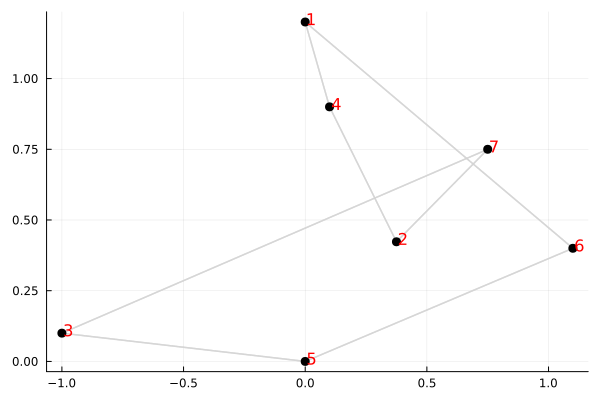

In [14]:

#Fully connected graph with 7 edges
a = Node("a",[0., 1.2])
b = Node("b",[0.375, 0.423])
c = Node("c",[-1.,0.1])
d = Node("d",[0.1,0.9])
e = Node("e",[0.,0.])
f = Node("f",[1.1, 0.4])
g = Node("g",[.75,.75])
node_list = [a,b,c, d,e, f, g]
#Edges are fully connected
edge1 = Edge(a,b, 4.)
edge2 = Edge(a,c, 8.)
edge3 = Edge(a, d, 11.)
edge4 = Edge(a, e, 8.)
edge5 = Edge(a, f, 7.)
edge6 = Edge(a, g, 1.)
edge7 = Edge(b, c, 6.)
edge8 = Edge(b, d, 2.)
edge9 = Edge(b, e, 4.)
edge10 = Edge(b, f, 7.)
edge11 = Edge(b, g, 2.)
edge12 = Edge(c, d, 7.)
edge13 = Edge(c, e, 1.)
edge14 = Edge(c, f, 6.)
edge15 = Edge(c, g, 3.)
edge16 = Edge(d, e, 5.)
edge17 = Edge(d, f, 4.)
edge18 = Edge(d, g, 8.)
edge19 = Edge(e, f, 2.)
edge20 = Edge(e, g, 7.)
edge21 = Edge(f, g, 3.)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10, edge11,
                edge12, edge13, edge14, edge15, edge16,
                edge17, edge18, edge19, edge20, edge21]
#creates the graph
tsp_test2 = Graph("Test2",node_list,edge_list)

score, test2_graph = lkh_subgradient(tsp_test2, t_k_method = "1/k")
plot_graph(test2_graph)
# score

Ici, nous le testons à nouveau sur un graphe entièrement connecté différent avec 7 nœuds. Il ne converge pas avec "1/k" pour les poids, mais fonctionne avec "poids/k"

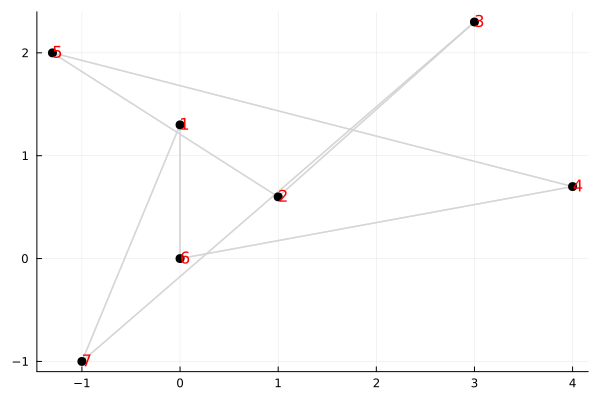

In [15]:

#Fully connected graph with 7 edges
a = Node("a",[0.,1.3])
b = Node("b",[1.,0.6])
c = Node("c",[3.,2.3])
d = Node("d",[4.,0.7])
e = Node("e",[-1.3,2.])
f = Node("f",[0.,0.])
g = Node("g",[-1., -1.])
node_list = [a,b,c, d,e, f, g]
#Edges are fully connected
edge1 = Edge(a,b, 3.)
edge2 = Edge(a,c, 2.)
edge3 = Edge(a, d, 11.)
edge4 = Edge(a, e, 12.)
edge5 = Edge(a, f, 6.)
edge6 = Edge(a, g, 10.)
edge7 = Edge(b, c, 4.)
edge8 = Edge(b, d, 10.)
edge9 = Edge(b, e, 8.)
edge10 = Edge(b, f, 7.)
edge11 = Edge(b, g, 4.)
edge12 = Edge(c, d, 7.)
edge13 = Edge(c, e, 11.)
edge14 = Edge(c, f, 6.)
edge15 = Edge(c, g, 3.)
edge16 = Edge(d, e, 10.)
edge17 = Edge(d, f, 4.)
edge18 = Edge(d, g, 8.)
edge19 = Edge(e, f, 9.)
edge20 = Edge(e, g, 7.)
edge21 = Edge(f, g, 10.)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10, edge11,
                edge12, edge13, edge14, edge15, edge16,
                edge17, edge18, edge19, edge20, edge21]
#creates the graph
tsp_test2 = Graph("Test2",node_list,edge_list)

score, test2_graph = lkh_subgradient(tsp_test2, t_k_method = "weights/k")
plot_graph(test2_graph)
# score

## Testing algorithms on TSP instances

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
sum of weights 1642.0


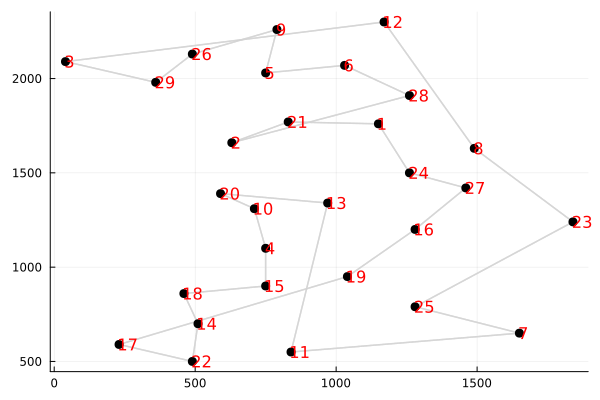

In [16]:
bays_29 = graph_from_tsp("../../instances/stsp/bays29.tsp","graphe")[1]
cycle = rsl(bays_29, nodes(bays_29)[1], "Kruskal")
println("sum of weights ", sum_of_weights(cycle))
plot_graph(cycle)


sum of weights 1670.0


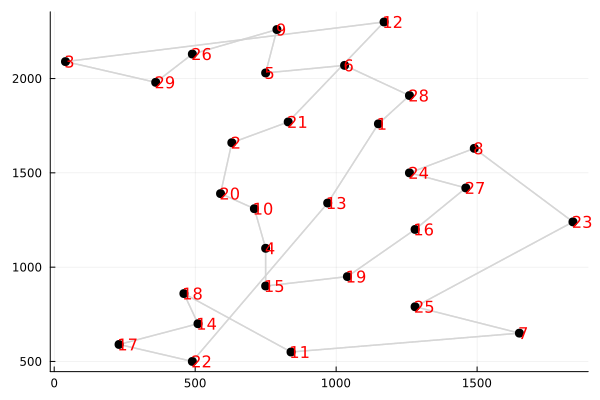

In [17]:
cycle = rsl(bays_29, nodes(bays_29)[1], "Prims")
println("sum of weights ", sum_of_weights(cycle))
plot_graph(cycle)

### testing hk sur gr17 et bays29

Nous testons ici l'algorithme lkh sur la plus petite instance tsp.Nous avons laissé l'algorithme fonctionner pendant une heure et il ne converge pour aucune des stratégies . (nous avons vérifié la norme du vecteur tk pour voir si elle diminuait, mais ce n'est pas le cas/). Voici quelques exemples de ce que cela donne pour 100 000 itérations.

In [18]:
gr17_graph, gr17_nodes = graph_from_tsp("../../instances/stsp/gr17.tsp","graphe1")
println("running h_k_algorithm on gr17")
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "1/k", departure_node_selector = random_departure_node_selector)
println(total_distance)

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
running h_k_algorithm on gr17
k = 

10000 step= 0.0001 time = 0.01158905029296875 VK_norm 22


k = 20000 step= 5.0e-5 time = 0.00035881996154785156 VK_norm 20
k = 

30000 step= 3.3333333333333335e-5 time = 0.0003638267517089844 VK_norm 26


InterruptException: InterruptException:

In [19]:
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "weights/k", tree_algorithm = kruskal)


k = 10000 step= 3.192238652876314 time = 0.0003209114074707031 VK_norm 26
k = 

20000 step= 1.7210931379326235 time = 0.00029397010803222656 VK_norm 26


k = 30000 step= 1.1781444209596517 time = 0.0002918243408203125 VK_norm 26
k = 

40000 step= 0.8956090074102496 time = 0.0002930164337158203 VK_norm 26


k = 50000 step= 0.7223737403044547 time = 0.00028896331787109375 VK_norm 26
k = 

60000 step= 0.6052934407364787 time = 0.0002949237823486328 VK_norm 26


k = 70000 step= 0.5208719786886846 time = 0.0002949237823486328 VK_norm 24
k = 

80000 step= 0.45711697817598745 time = 0.0002989768981933594 VK_norm 26


k = 90000 step= 0.4072672548228443 time = 0.0002899169921875 VK_norm 26
k = 

100000 step= 0.3672209166265155 time = 0.0002918243408203125 VK_norm 26
 30.301095 seconds (165.02 M allocations: 8.810 GiB, 2.19% gc time, 0.13% compilation time)


(Inf, nothing)

In [20]:
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "weights/k", tree_algorithm = prims_algorithm)

k = 10000 step= 3.192238652876314 time = 0.0003581047058105469 VK_norm 26
k = 

20000 step= 1.7210931379326235 time = 0.0003590583801269531 VK_norm 26


k = 30000 step= 1.1781444209596517 time = 0.0003719329833984375 VK_norm 26
k = 

40000 step= 0.8956090074102496 time = 0.00036597251892089844 VK_norm 26


k = 50000 step= 0.7223737403044547 time = 0.0003571510314941406 VK_norm 24
k = 

60000 step= 0.6052934407364787 time = 0.0003581047058105469 VK_norm 24


k = 70000 step= 0.5208719786886846 time = 0.00035881996154785156 VK_norm 26
k = 

80000 step= 0.45711697817598745 time = 0.00037407875061035156 VK_norm 24


k = 90000 step= 0.4072672548228443 time = 0.0003879070281982422 VK_norm 26
k = 

100000 step= 0.3672209166265155 time = 0.0003600120544433594 VK_norm 26
 37.574471 seconds (347.63 M allocations: 17.670 GiB, 3.42% gc time, 0.01% compilation time)


(Inf, nothing)

In [21]:
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "sqrt", departure_node_selector = random_departure_node_selector)

k = 10000 step= 0.1 time = 0.0003571510314941406 VK_norm 14
k = 

20000 step= 0.07071067811865475 time = 0.0003578662872314453 VK_norm 22


k = 30000 step= 0.05773502691896258 time = 0.000354766845703125 VK_norm 20
k = 

40000 step= 0.05 time = 0.00037217140197753906 VK_norm 20


k = 50000 step= 0.044721359549995794 time = 0.0003600120544433594 VK_norm 18
k = 

60000 step= 0.0408248290463863 time = 0.00036215782165527344 VK_norm 24


k = 70000 step= 0.03779644730092272 time = 0.0003609657287597656 VK_norm 22
k = 

80000 step= 0.035355339059327376 time = 0.00036215782165527344 VK_norm 24


k = 90000 step= 0.03333333333333333 time = 0.0003609657287597656 VK_norm 22
k = 

100000 step= 0.03162277660168379 time = 0.0003578662872314453 VK_norm 18
 37.725864 seconds (347.03 M allocations: 17.581 GiB, 3.43% gc time)


(Inf, nothing)

In [23]:
@time bays_res = lkh_subgradient(bays_29, t_k_method="weights/k", tree_algorithm= kruskal, departure_node_selector = random_departure_node_selector)

k = 10000 step= 12.970927978913094 time = 0.0015931129455566406 VK_norm 52
k = 

20000 step= 7.306519935368357 time = 0.0016109943389892578 VK_norm 52


k = 30000 step= 5.085625702908903 time = 0.0015871524810791016 VK_norm 52
k = 

40000 step= 3.900137532343411 time = 0.001605987548828125 VK_norm 52


k = 50000 step= 3.1628575209361234 time = 0.0015709400177001953 VK_norm 52
k = 

60000 step= 2.6600104930126074 time = 0.0015799999237060547 VK_norm 52


k = 70000 step= 2.29512064637375 time = 0.001744985580444336 VK_norm 52
k = 

80000 step= 2.018263187734472 time = 0.0015940666198730469 VK_norm 52


k = 90000 step= 1.8010096987050452 time = 0.0015950202941894531 VK_norm 52
k = 

100000 step= 1.625982759793584 time = 0.001589059829711914 VK_norm 52
162.979954 seconds (679.37 M allocations: 29.013 GiB, 1.55% gc time, 0.01% compilation time)


(Inf, nothing)